# ARIMA model for time series forecasting of Confiremed cases of COVID-19 in Ontario
### - In the following notebook, the Autoregressive Integrated Moving Average Model will be utilized to make predictions on the confiremed cases in Ontario.
### - Before jumping into the time forecasting  process, let's visvalize the data a bit more.

In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global_1.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_deaths_global.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_recovered_global.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global.csv


In [17]:
# Importing all the necassaries libraries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set()
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno
# Importing ARIMA based libraries
from statsmodels.tsa.ar_model import AR
from random import random
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
# Importing Autocorrelation based libraries
from pandas import datetime
from pandas.plotting import autocorrelation_plot

In [18]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [19]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [20]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


In [21]:
nRowsRead = 1000 # specify 'None' if want to read whole file
### time_series_covid19_confirmed_global_1.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('../input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'time_series_covid19_confirmed_global_1.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 264 rows and 91 columns


In [22]:
df1.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,444,484,521,555,607,665,714,784,840,906
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,400,409,416,433,446,467,475,494,518,539
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,564,583,601,601,638,646,659,673,673,696
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,19,19


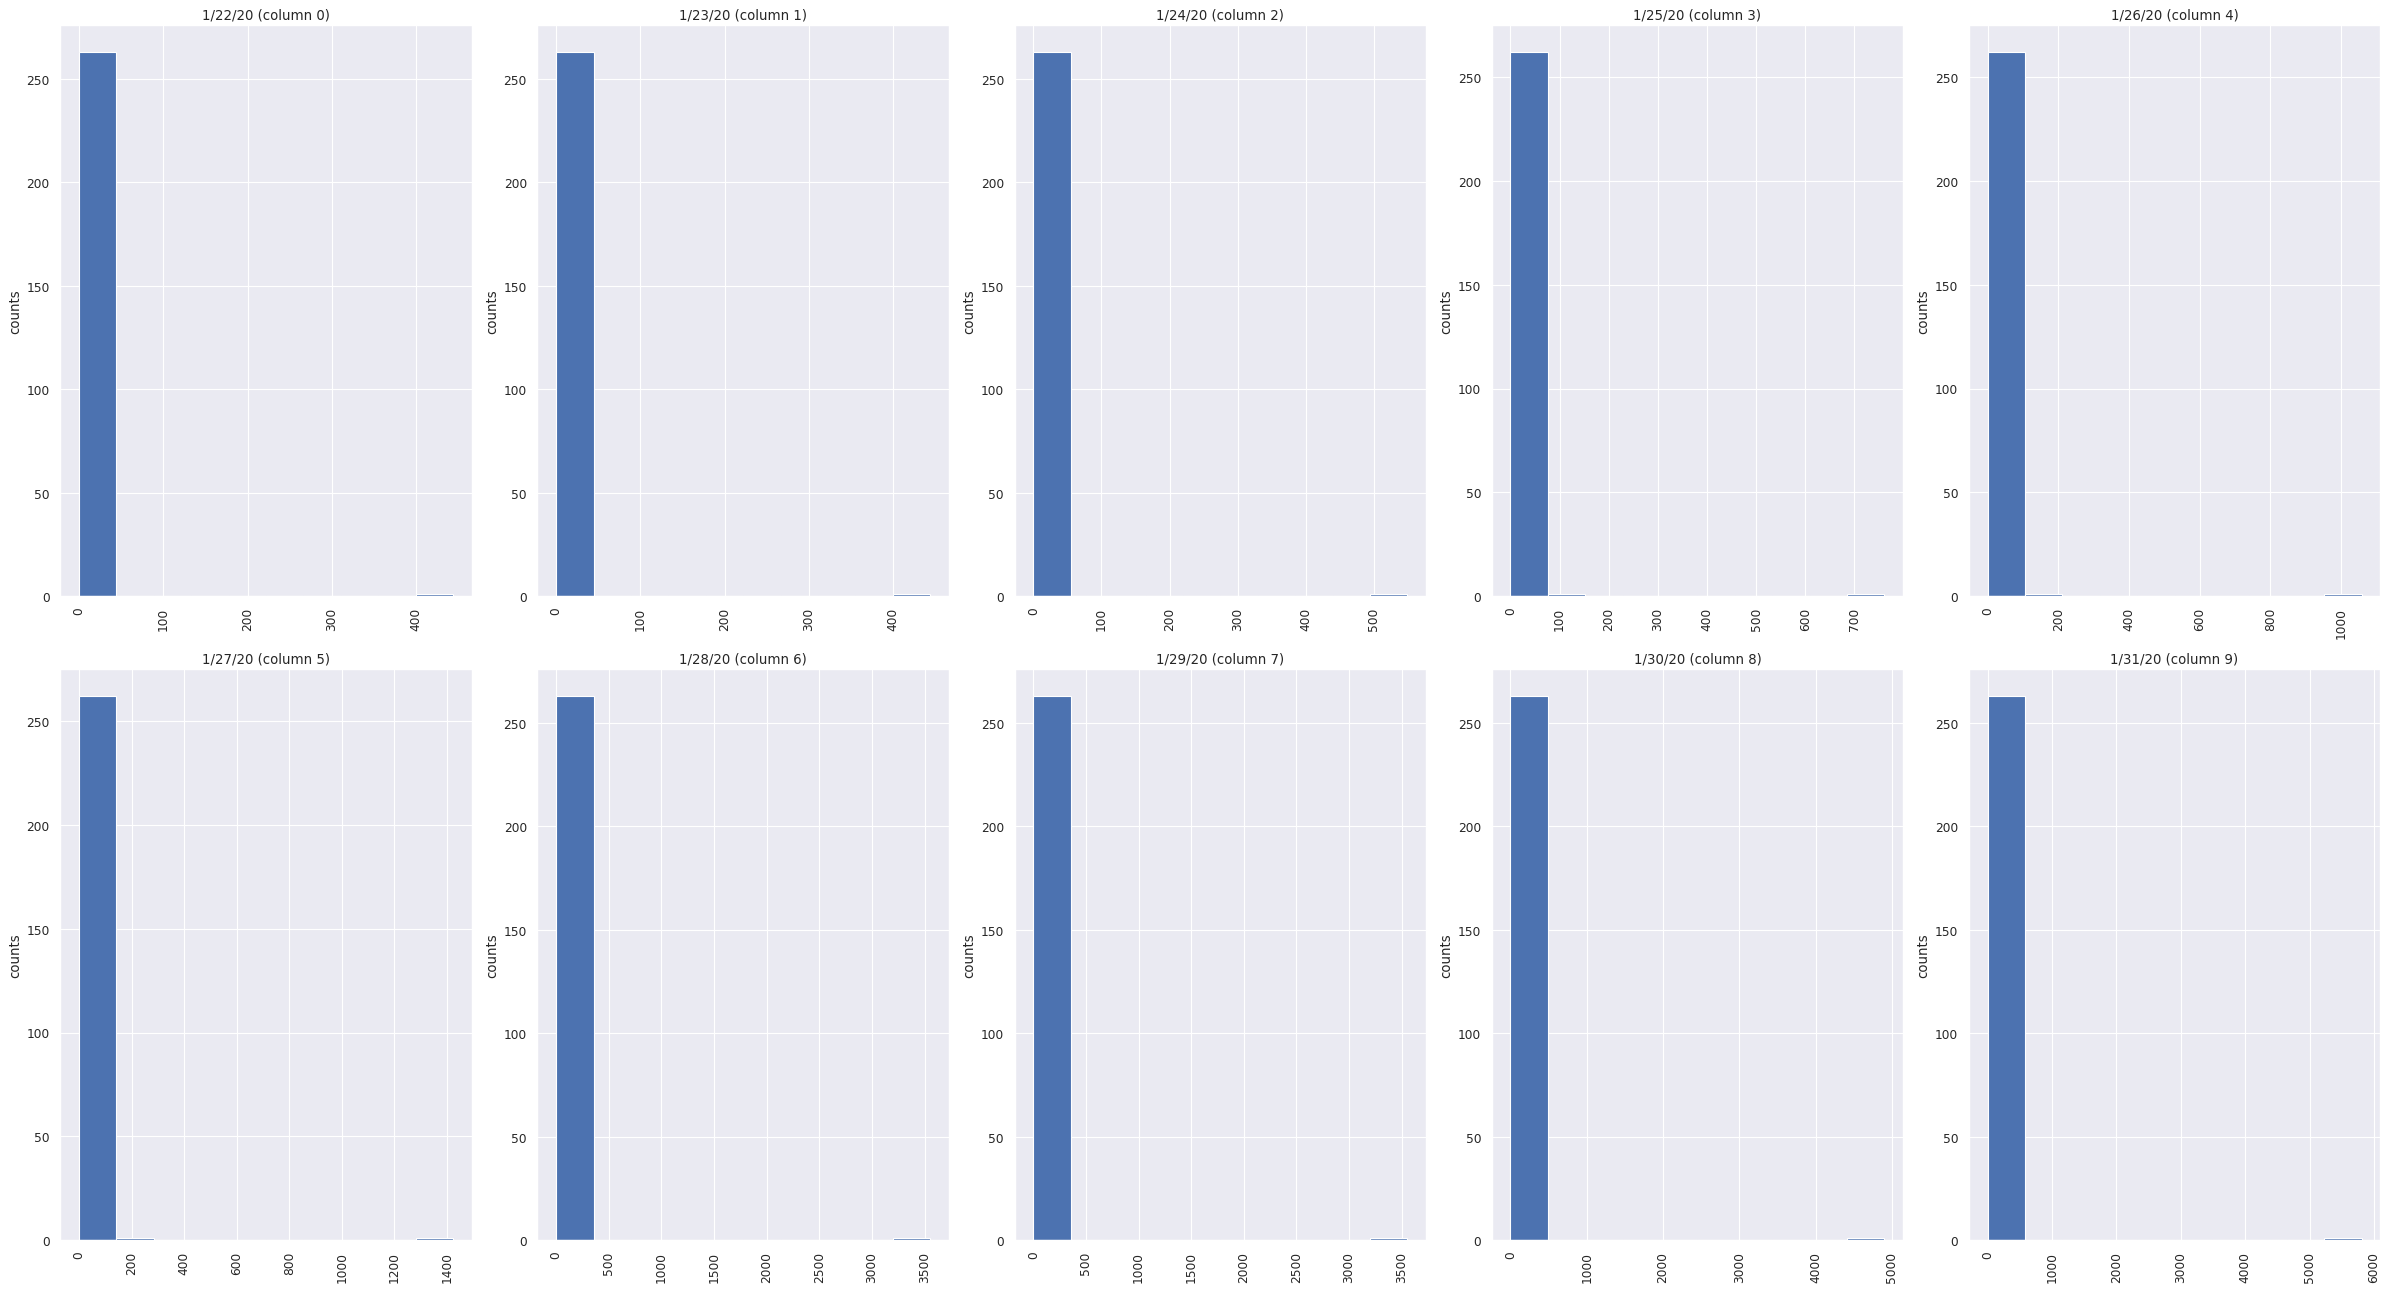

In [23]:
plotPerColumnDistribution(df1, 10, 5)

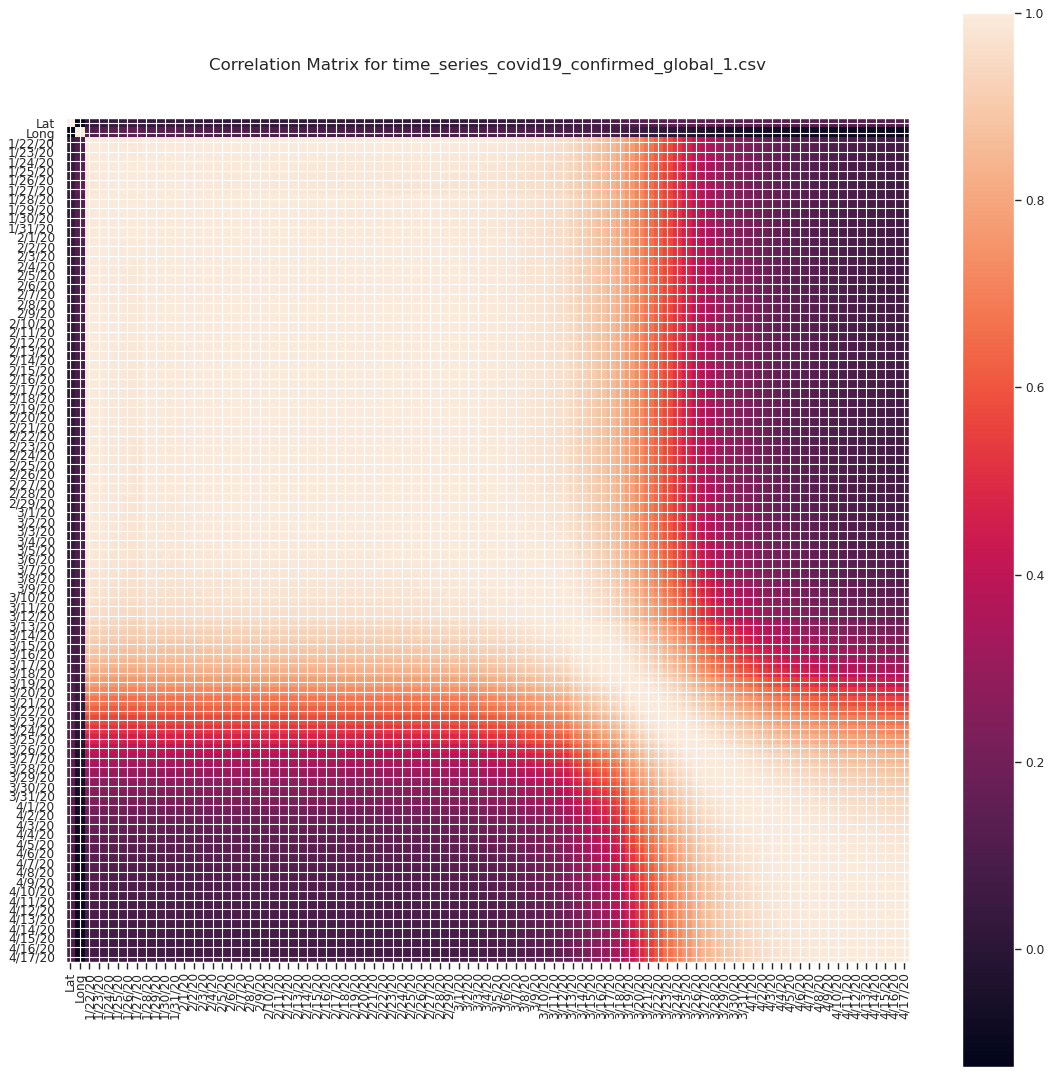

In [24]:
plotCorrelationMatrix(df1, 17)

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:3

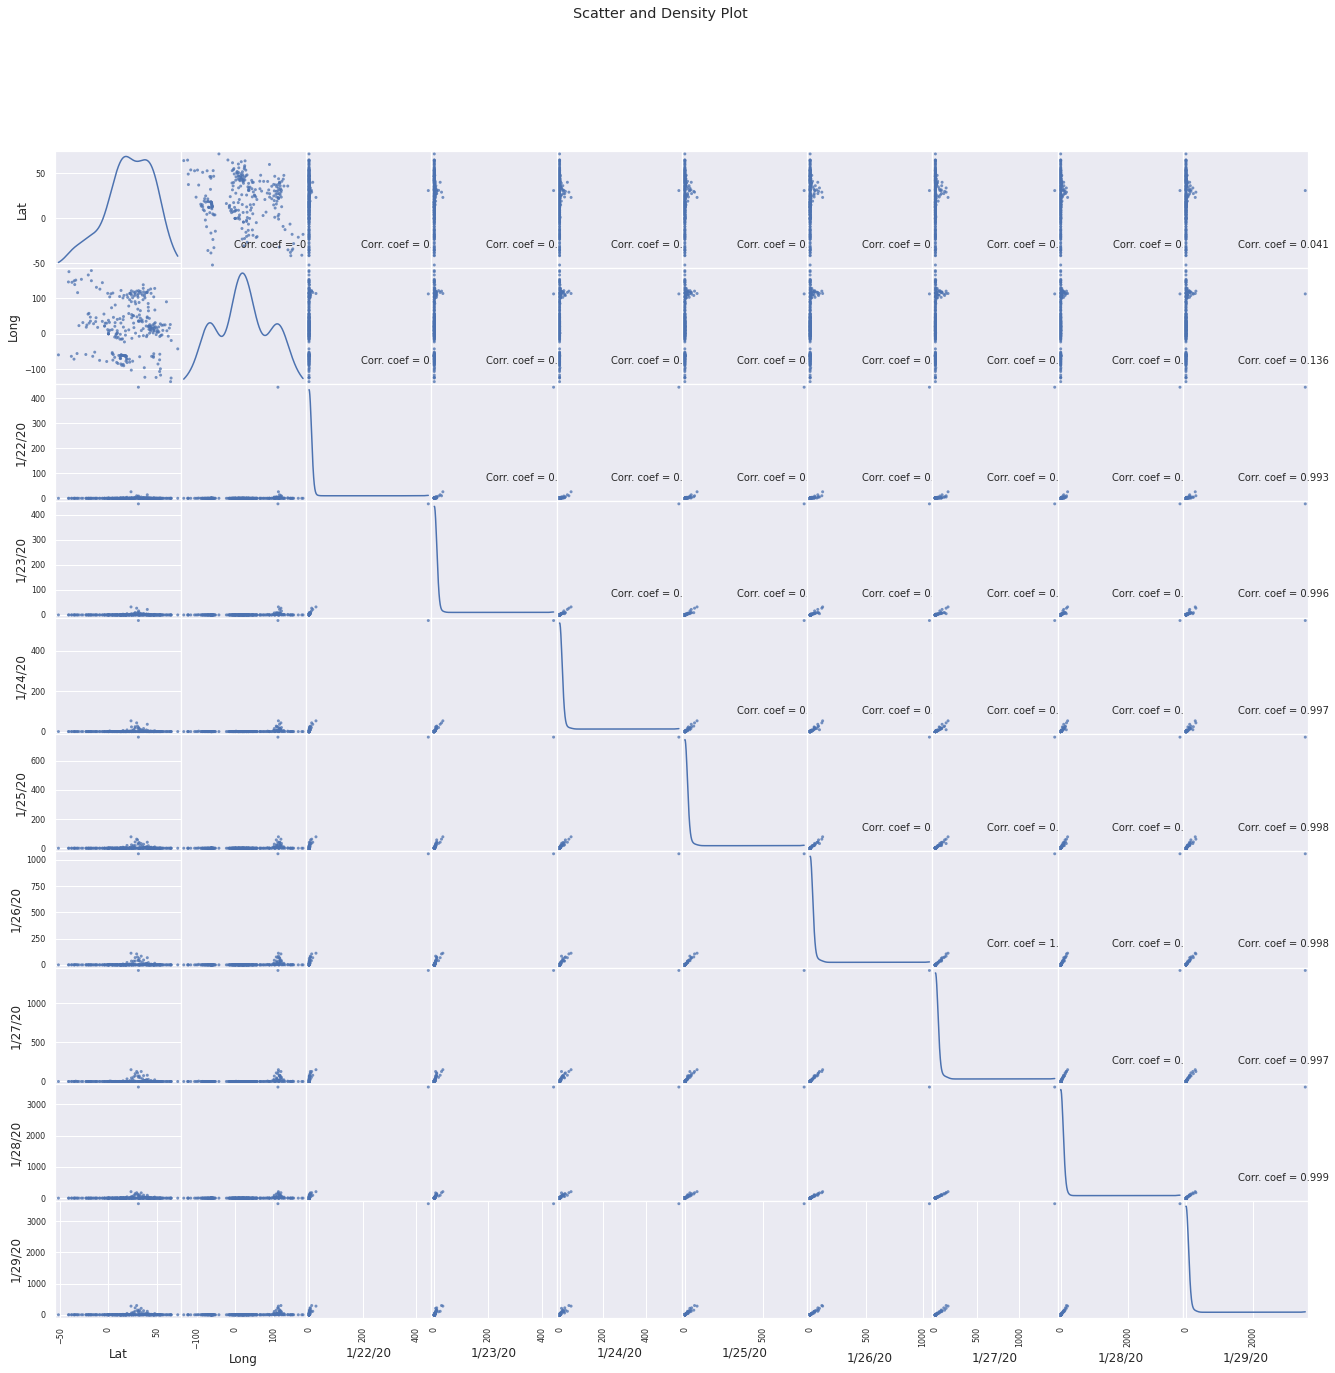

In [25]:
plotScatterMatrix(df1, 20, 10)

In [26]:
df1.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20',
       '4/9/20', '4/10/20'

### - Specifically obatining confirmed cases in ontario. 

In [27]:
# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
y=df1.loc[df1['Province/State']=='Ontario'].iloc[0,4:]
s = pd.DataFrame({'Ontario':y})
print(s)

        Ontario
1/22/20       0
1/23/20       0
1/24/20       0
1/25/20       0
1/26/20       1
...         ...
4/13/20    7470
4/14/20    7953
4/15/20    8447
4/16/20    9840
4/17/20   10456

[87 rows x 1 columns]


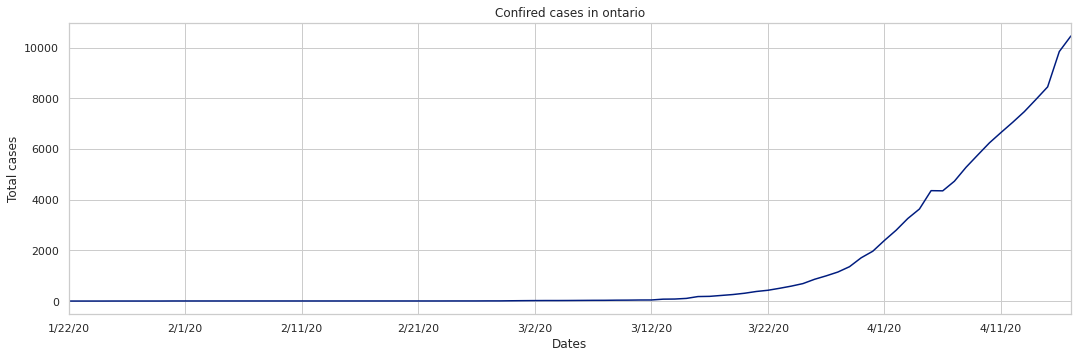

In [28]:
# Plotting the confirmed cases in ontario, to observe the trend in the number of cases
y.index.freq = 'MS'
ax = y.plot(figsize = (16,5), title = "Confired cases in ontario")
ax.set(xlabel='Dates', ylabel='Total cases');

### - Trying to plot the autocorrelation plot of the time series, this helps in plotting large number of lags in the time series.

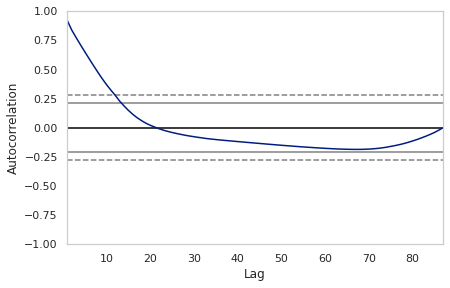

In [29]:
series =y
autocorrelation_plot(series)
plt.show()

### - Based on the Autocorrelation plot, it is fairly obvious that the first 20 lags have a posituve correlation. If we observe closely, the first few lags have very significant correation (especially the first 3 lags). 
### - So in the further portions, i will be utilizing the first 3 lags as a good starting point for the ARIMA model,to make predictions.

## - Developing the ARIMA model
### - There will be two instances carried out below, the first block involves analyzing the residual errors and their densities, followed by block two where predictions will be carried out on the confirmed cases.
## - BLOCK 1
### - In this portion, the ARIMA model will be fitted on the number of confirmed cases in ontario and the residual errors will be analysed. 


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   39
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -241.700
Method:                       css-mle   S.D. of innovations            116.043
Date:                Wed, 22 Apr 2020   AIC                            493.401
Time:                        04:23:51   BIC                            501.718
Sample:                             1   HQIC                           496.385
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        210.7038    168.005      1.254      0.210    -118.580     539.988
ar.L1.D.y      0.1859      0.148      1.260      0.208      -0.103       0.475
ar.L2.D.y      0.4117      0.135      3.042      0.0

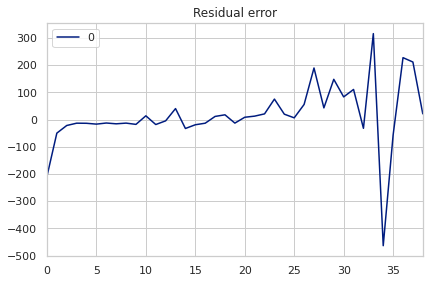

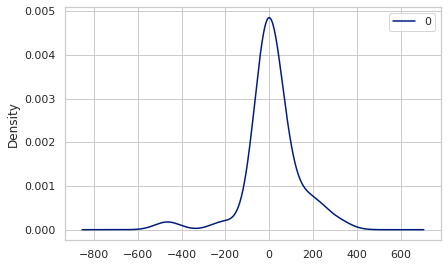

                0
count   39.000000
mean    15.465594
std    120.204667
min   -463.867805
25%    -17.046964
50%      6.541974
75%     41.875573
max    316.371376


In [45]:
# Developing ARIMA model for the Confiremed cases in Ontario
Y = y.to_numpy()
Y = Y[40:80]
# fit model
model = ARIMA(Y, order=(3,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.title('Residual error')
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

### - The distribution of residual errors as shown above indicate that there is a bias in the prediction.
### - Now, since the above kernal was carried out on the entire dataset, in Block 2 i will be using some of it as training data to develop a predictive model, using of course the ARIMA model.
## - BLOCK 2 - Predictions
### - Utilizing ARIMA to predict future time steps.

predicted=5697.025816, expected=5759.000000
predicted=6254.641764, expected=6237.000000
predicted=6692.658112, expected=6648.000000
predicted=7072.503580, expected=7049.000000
predicted=7432.185965, expected=7470.000000
predicted=7857.181678, expected=7953.000000
predicted=8379.088664, expected=8447.000000
predicted=8914.477839, expected=9840.000000
predicted=10708.593785, expected=10456.000000
Test MSE: 104701.854


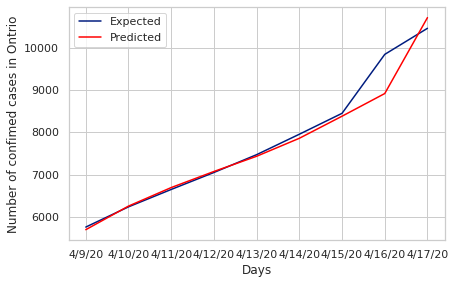

In [50]:
#Making predictions
size = int(len(y) * 0.9)
train, test = y[0:size], y[size:len(y)]
history = [y for y in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test,label= 'Expected')
plt.plot(predictions, color='red',label = 'Predicted')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Number of confimed cases in Ontrio')
plt.show()